Notebook 2 - Explore Profiles :
après les features de résultats, nous analysons les features de profil (inputs) et leurs éventuels dérivés caractérisants les bâtiments dont on souhaite prédire les niveaux de consommation et d'émission, i.e. tout nouveau bâtiment n'ayant fait l'objet d'aucune campagne de mesure.

- PEP8 check

In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
# importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Pour afficher tout le contenu d'une valeur
pd.set_option('display.max_colwidth', -1)
# Pour afficher toutes les colonnes
pd.options.display.max_columns = 100

In [3]:
# récupérer les données
dat = pd.read_csv('dat2.csv')

In [4]:
# contrôler la taille des données
dat.shape

(6485, 40)

## B.2. features de profil

Les informations "Profile" sont les caractéristiques connues des bâtiments sans avoir besoin de se déplacer pour effectuer un relevé. <br/>
nb on précise (x, y) <br/>
x : le nb de valeurs inconnues dans les relevés,<br/>
y : lorsque disponible le nb de valeurs uniques.<br/>

- on distingue 2 sortes d'informations : textuelles (type object) ou numériques (int64 ou float64)

- B.2.1 les données catégorielles sur la nature des bâtiments:  <br/>
tous déterminés : <br/>
BuildingType (0, 8) <br/>
PrimaryPropertyType (0, 32) <br/>
pas tous déterminés :  <br/>
LargestPropertyUseType (156, 57) <br/>
SecondLargestPropertyUseType (3478, 50) <br/>
ThirdLargestPropertyUseType (5560, 45) <br/>
ListOfAllPropertyUseTypes (136, 488) : on pourra éventuellement détecter combien il y a de property use type avec ce feature <br/>
<br/>
- B.2.2. les données numériques de surface: <br/>
PropertyGFATotal (0) <br/>
PropertyGFABuilding(s) (0) <br/>
PropertyGFAParking (0) <br/>
LargestPropertyUseTypeGFA (156) <br/>
SecondLargestPropertyUseTypeGFA (3478) <br/>
ThirdLargestPropertyUseTypeGFA (5560) <br/>
<br/>
- B.2.3. les données numériques caractéristant les bâtiments :  <br/>
NumberofBuildings (8) <br/>
NumberofFloors (8) <br/>
YearBuilt (0) <br/>
<br/>
- B.2.4. les données textuelles, catégorielles et numériques de localisation: <br/>
CouncilDistrictCode (0) qui se cache derrière une valeur numérique <br/>
Neighborhood (0, 19) <br/>
Address, ZipCode & City : trop laborieux à valoriser <br/>
Latitude (0) <br/>
Longitude (0) <br/>
<br/>



 ### B.2.1 Nature des bâtiments

#### BuildingType
C'est une classification des services de la ville de Seattle

In [5]:
# identifier les valeurs unique de BuildingType
dat['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Text(0.5, 1.02, 'BuildingType')

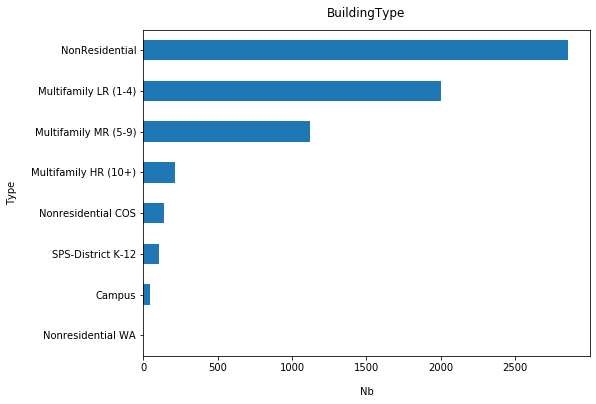

In [6]:
# observer la répartition des BuildingType
dat['BuildingType'].value_counts().plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Type', labelpad=14)
plt.title('BuildingType', y=1.02)

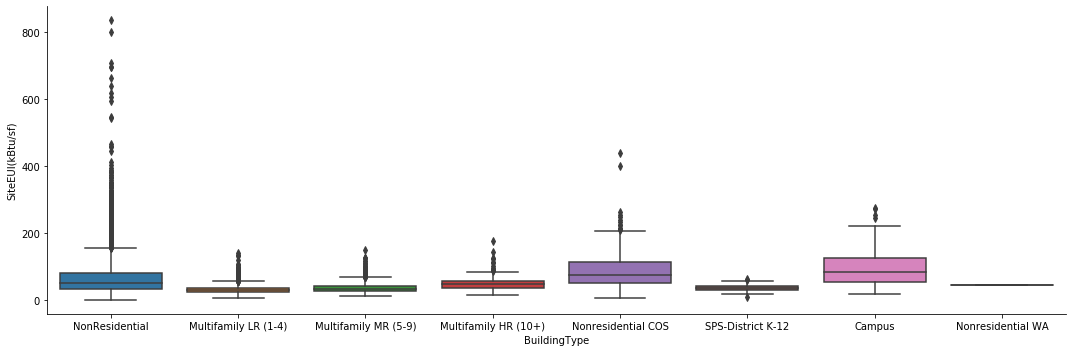

In [7]:
# visualiser les valeurs d'intensité d'energie pour chaque BuildingType
ax = sns.catplot(
    x='BuildingType',
    y='SiteEUI(kBtu/sf)',
    kind='box',
    data=dat,
    order=dat['BuildingType'].value_counts().index,
    height=5,
    aspect=15/5)
plt.xticks(rotation=0)
plt.show()

In [8]:
# isoler un petit aperçu
dat.loc[dat['BuildingType'] == 'Nonresidential WA', ['PropertyName']]

,PropertyName
6471,Burke Museum


SPS, COS et WA sont les abbréviation de Seattle Public Schools, City of Seattle et (state of) WAshington : il s'agit donc de bâtiments publics de la ville ou l'état, et donc non résidentiels.

En résumé le BuildingType permet essentiellement de distinguer Résidentiel - Non Résidentiel, parmis les résidentiel, on ne retrouve que 3 dénominations, qui sont fonction du nombre d'étages allouées aux habitants.
Il y aurait une interprétation possible avec le nombre d'étages du(des) building(s) considérés.



In [9]:
# créer une classe
dat['N_D_BuildingType'] = dat['BuildingType']
dat['N_D_BuildingType'].replace(
    {'NonResidential': 1,
     'Nonresidential COS': 1,
     'Multifamily MR (5-9)': 0,
     'SPS-District K-12': 1,
     'Multifamily LR (1-4)': 0,
     'Campus': 1,
     'Multifamily HR (10+)': 0,
     'Nonresidential WA': 1},
    inplace=True)

Text(0.5, 1.02, 'Binary BuildingType')

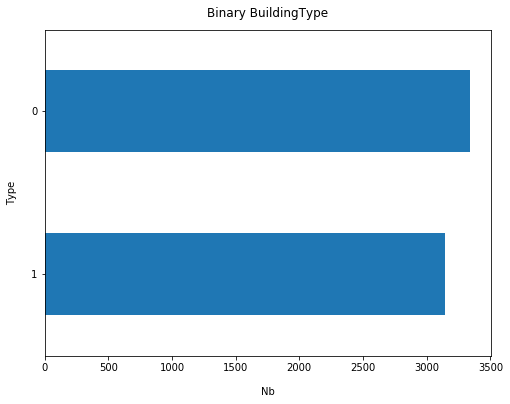

In [10]:
# dénombrer les BuildingType par classe
dat['N_D_BuildingType'].value_counts().plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Type', labelpad=14)
plt.title('Binary BuildingType', y=1.02)

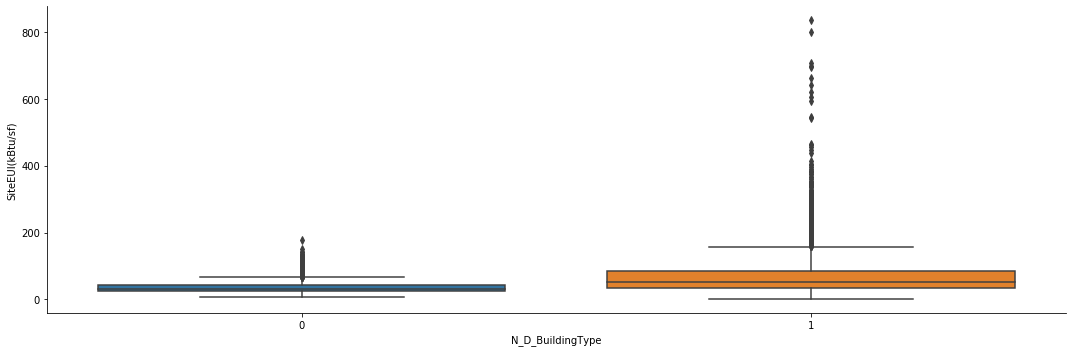

In [11]:
# visualiser les valeurs d'intensité d'energie pour chaque BuildingType
ax = sns.catplot(
    x='N_D_BuildingType',
    y='SiteEUI(kBtu/sf)',
    kind='box',
    data=dat,
    order=dat['N_D_BuildingType'].value_counts().index,
    height=5,
    aspect=15/5)
plt.xticks(rotation=0)
plt.show()

- Cette nouvelle variable va nous servir à découper judicieusement les données (stratify), de manière à garder une représentation dans la répartition des buildings résidentiels et non résidentiels.

#### PrimaryPropertyType
C'est l'usage majoritaire pour une propriété.
La source ci-dessous décrit la catégorisation des Property Types :
https://portfoliomanager.zendesk.com/hc/en-us/articles/213426297-Which-Property-Types-are-available-in-Portfolio-Manager-

on découvre ainsi que les types sont une décomposition niveau 2 d'une première typologie de 17 types (dont Other, qui sert parfois de fourre-tout pour le niveau 2 également). 31 types sont dénombrés dans ce qui reste des relevés.

In [12]:
# compter le nombre de libellés PrimaryPropertyType
dat['PrimaryPropertyType'].unique().size

31

Text(0.5, 1.02, 'PrimaryPropertyType (all)')

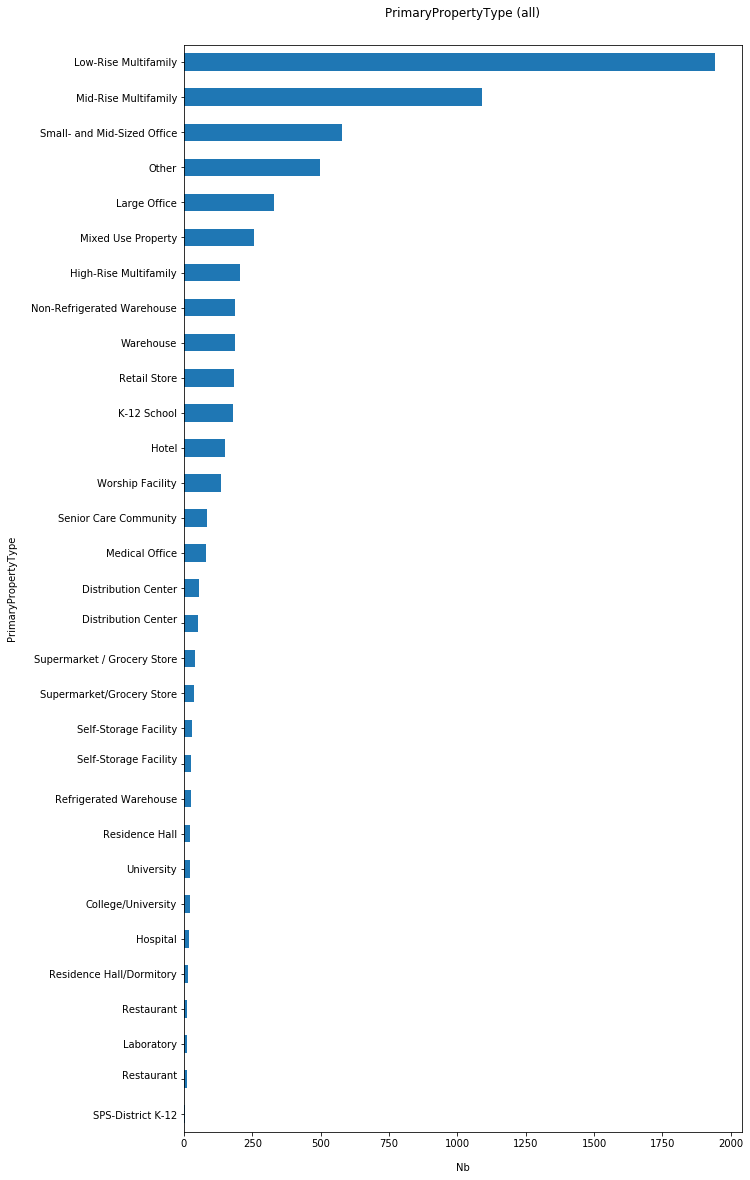

In [13]:
# visualiser la répartition par PrimaryPropertyType
dat['PrimaryPropertyType'].value_counts()[:31].plot(
    kind='barh',
    figsize=(10, 20)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('PrimaryPropertyType', labelpad=14)
plt.title('PrimaryPropertyType (all)', y=1.02)

In [14]:
# lister des libellés
dat['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Low-Rise Multifamily', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store'], dtype=object)

- Contrairement à ce que suggérait le BuildingType, il y a une très nette majorité d'usage résidentiel, ce qui apparait contradictoire. Le PrimaryPropertyType étant recalculé, il n'apporte pas une information plus précise que les 1er 2eme et 3eme PropertyUseType. <br/>
- Ces derniers présentent l'avantage d'être associés aux surfaces (ces surfaces entrent justement dans la détermination du PrimaryPropertyType) mais le désavantage de ne pas être toujours spécifié. 
- enfin, on constate des libellés mal renseignés.

### Rationnalisation du PrimaryPropertyType
L'idée est de rendre ce feature exploitable afin de tester l'apport d'une décomposition de premier niveau. <br/>

In [15]:
# copier dans une nouvelle colonne
dat['N_PrimaryPropertyType'] = dat['PrimaryPropertyType']

In [16]:
# appliquer les remplacements
dat['N_PrimaryPropertyType'].replace('College/University',
                                     'N_Education', inplace=True)
dat['N_PrimaryPropertyType'].replace('K-12 School',
                                     'N_Education', inplace=True)
dat['N_PrimaryPropertyType'].replace('SPS-District K-12',
                                     'N_Education', inplace=True)
dat['N_PrimaryPropertyType'].replace('University',
                                     'N_Education', inplace=True)
dat['N_PrimaryPropertyType'].replace('Residence Hall/Dormitory',
                                     'Residence Hall', inplace=True)
dat['N_PrimaryPropertyType'].replace('Supermarket / Grocery Store',
                                     'Supermarket/Grocery Store', inplace=True)
dat['N_PrimaryPropertyType'].replace('Restaurant\n',
                                     'Restaurant', inplace=True)
dat['N_PrimaryPropertyType'].replace('Distribution Center\n',
                                     'Distribution Center', inplace=True)
dat['N_PrimaryPropertyType'].replace('Self-Storage Facility\n',
                                     'Self-Storage Facility', inplace=True)
dat['N_PrimaryPropertyType'].replace('Self-Storage Facility\n',
                                     'Self-Storage Facility', inplace=True)
dat['N_PrimaryPropertyType'].replace('Mid-Rise Multifamily',
                                     'N_Residential', inplace=True)
dat['N_PrimaryPropertyType'].replace('Low-Rise Multifamily',
                                     'N_Residential', inplace=True)
dat['N_PrimaryPropertyType'].replace('High-Rise Multifamily',
                                     'N_Residential', inplace=True)
dat['N_PrimaryPropertyType'].replace('Residence Hall',
                                     'N_Residential', inplace=True)
dat['N_PrimaryPropertyType'].replace('Other',
                                     'N_Undefined', inplace=True)
dat['N_PrimaryPropertyType'].replace('Mixed Use Property',
                                     'N_Undefined', inplace=True)
dat['N_PrimaryPropertyType'].replace('Small- and Mid-Sized Office',
                                     'N_Office', inplace=True)
dat['N_PrimaryPropertyType'].replace('Large Office',
                                     'N_Office', inplace=True)

In [17]:
# compter le nb de libellés rationalisé
dat['N_PrimaryPropertyType'].unique().size

18

Text(0.5, 1.02, 'Rationalized PrimaryPropertyType (Top 5)')

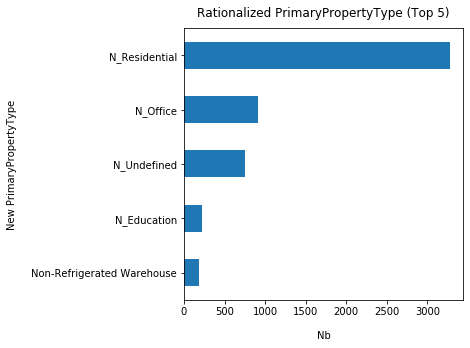

In [18]:
# afficher la nouvelle répartition
dat['N_PrimaryPropertyType'].value_counts()[:5].plot(
    kind='barh',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('New PrimaryPropertyType', labelpad=14)
plt.title('Rationalized PrimaryPropertyType (Top 5)', y=1.02)

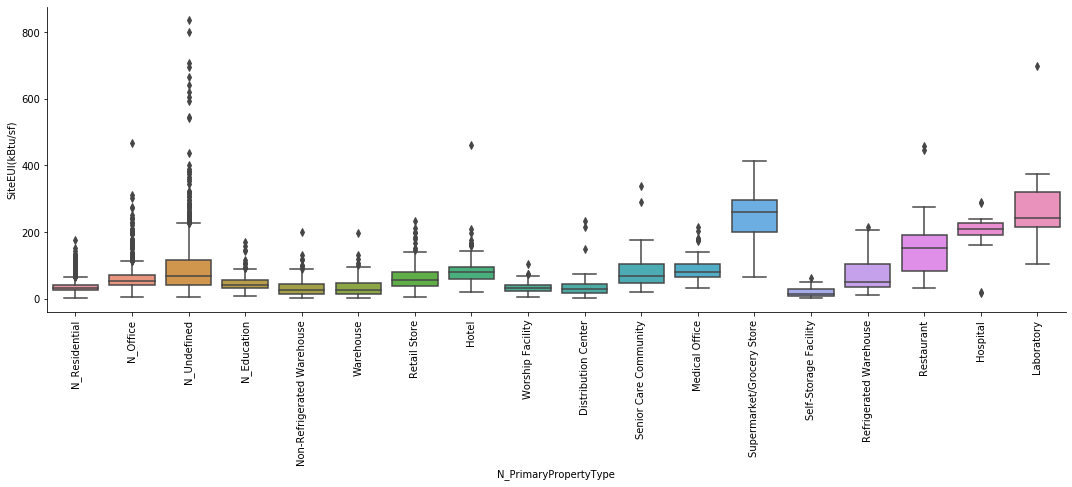

In [19]:
# visualiser les intensités d'énergie selon les N_PrimaryPropertyTypes
sns.catplot(
    x='N_PrimaryPropertyType',
    y='SiteEUI(kBtu/sf)',
    kind='box',
    data=dat,
    order=dat['N_PrimaryPropertyType'].value_counts()[:18].index,
    height=5,
    aspect=15/5)
plt.xticks(rotation=90)
plt.show()

#### ListOfAllPropertyUseTypes, et 1er, 2ème et 3èmé  PropertyUseType
 
 On retrouve l'usage (associé à une déclaration de surface), par ordre d'importance des 3 premiers. <br/>
 La liste conduit à la combinaison des usages déclarés.<br/>
 

In [20]:
# décompter les ListOfAllPropertyUseTypes absents
dat['ListOfAllPropertyUseTypes'].isna().sum()

121

In [21]:
# identifier si dans ce cas le PrimaryPropertyType existe
cols = ['PrimaryPropertyType']
mask = dat['ListOfAllPropertyUseTypes'].isna()
temp = dat[cols][mask]
temp['PrimaryPropertyType'].unique()

array(['Hotel', 'Distribution Center', 'SPS-District K-12',
       'Large Office', 'Retail Store', 'Small- and Mid-Sized Office',
       'Mixed Use Property', 'Laboratory', 'Self-Storage Facility',
       'Other', 'Non-Refrigerated Warehouse', 'Senior Care Community',
       'Mid-Rise Multifamily', 'High-Rise Multifamily',
       'Low-Rise Multifamily', 'Medical Office', 'Worship Facility',
       'Supermarket/Grocery Store', 'Restaurant', 'Hospital'],
      dtype=object)

In [22]:
# décompter les LargestPropertyUseType absents
dat['LargestPropertyUseType'].isna().sum()

141

- on pourrait envisager de combler les manques de LargestPropertyUseType (& surface) par le PrimaryPropertyType (& surface), mais cela ajoutera à la confusion des catégories qui sont libellées différemment. 
- de plus, il manquerait la surface associée.

In [23]:
# supprimer les cas inconnus pour ne pas apprendre d'informations incohérentes.
dat.dropna(axis=0, subset=['LargestPropertyUseType'], inplace=True)
print(dat.shape)

(6344, 42)


In [24]:
# vérifier s'il manque toujours des ListOfAllPropertyUseTypes
dat['ListOfAllPropertyUseTypes'].isna().sum()

0

In [25]:
# remplacer les UseType contenant une virgule
dat['ListOfAllPropertyUseTypes'].replace(
    'Repair Services (Vehicle, Shoe, Locksmith, etc)',
    'Repair Services',
    inplace=True)
dat['ListOfAllPropertyUseTypes'].replace(
    'Personal Services (Health/Beauty, Dry Cleaning, etc)',
    'Personal Services',
    inplace=True)

In [26]:
# décompter le usages vs nb d'usage déclarés via la présence de ','
# compter le nb d'items pour chaque ligne
cnt = []
nbPropUse = []
for rows in dat['ListOfAllPropertyUseTypes']:
    if rows != rows:
        nbPropUse.append(np.NaN)
    else:
        cnt.append(len(rows.split(',')))
        nbPropUse.append(len(rows.split(',')))

Text(0.5, 1.02, 'distribution des usages listés')

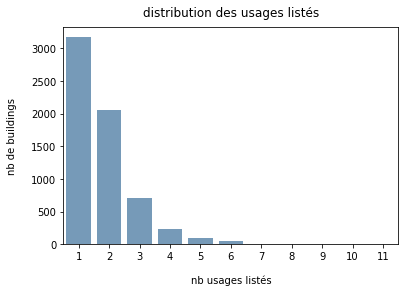

In [27]:
# afficher la répartition des nombres d'usages
plt.figsize = (8, 6)
sns.countplot(cnt, color='steelblue', alpha=0.8)
plt.xlabel('nb usages listés', labelpad=14)
plt.ylabel('nb de buildings', labelpad=14)
plt.title('distribution des usages listés', y=1.02)

- il n'y a donc que marginalement plus de 3 usages listés, on décide d'en faire un nouveau feature


In [28]:
# Dériver un feature contenant le nb d'Usages
dat['N_NbPropUse'] = nbPropUse

In [29]:
# Dériver un feature regroupant les usages >3 (nature indéterminée)
bins = [0, 1, 2, 3, np.inf]
values = [1, 2, 3, 4]
dat['N_D_NbPropUseRange'] = pd.cut(dat['N_NbPropUse'], bins, labels=values)

Text(0.5, 1.02, 'N_D_NbPropUseRange')

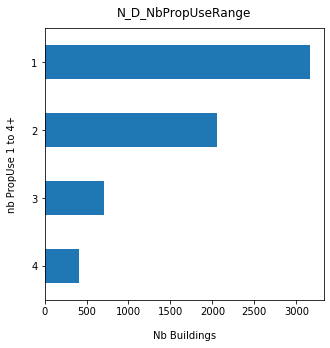

In [30]:
# afficher la nouvelle répartition nb d'usage regroupés
dat['N_D_NbPropUseRange'].value_counts().plot(
    kind='barh',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb Buildings', labelpad=14)
plt.ylabel('nb PropUse 1 to 4+', labelpad=14)
plt.title('N_D_NbPropUseRange', y=1.02)

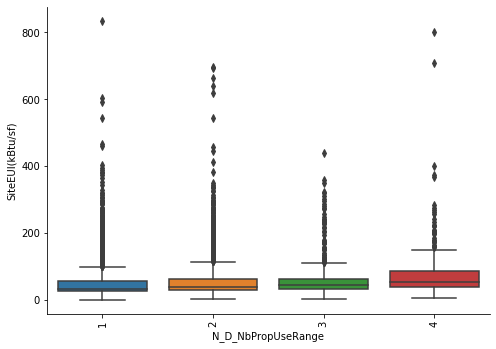

In [31]:
# visualiser l'intensité d'energie selon ces nb d'usages
ax = sns.catplot(x='N_D_NbPropUseRange',
                 y='SiteEUI(kBtu/sf)',
                 kind='box',
                 data=dat,
                 height=5,
                 aspect=7/5)
plt.xticks(rotation=90)
plt.show()

- le nb d'usages accroit l'intensité d'energie consommée

In [32]:
# nb précis de cas ayant 4+ UseType
dat[dat['N_D_NbPropUseRange'] > 3].shape

(415, 44)

- ce nouveau feature présente une évolution monotone croissante pour les valeurs médianes, la dispersion des valeurs > dernier quartile est d'autant plus grande que le Nb d'usage est limité.  

In [33]:
# appliquer le même renommage des libellés pour chaque rang d'UseType
dat['LargestPropertyUseType'].replace(
    'Repair Services (Vehicle, Shoe, Locksmith, etc)',
    'Repair Services',
    inplace=True)
dat['LargestPropertyUseType'].replace(
    'Personal Services (Health/Beauty, Dry Cleaning, etc)',
    'Personal Services',
    inplace=True)
dat['SecondLargestPropertyUseType'].replace(
    'Repair Services (Vehicle, Shoe, Locksmith, etc)',
    'Repair Services',
    inplace=True)
dat['SecondLargestPropertyUseType'].replace(
    'Personal Services (Health/Beauty, Dry Cleaning, etc)',
    'Personal Services',
    inplace=True)
dat['ThirdLargestPropertyUseType'].replace(
    'Repair Services (Vehicle, Shoe, Locksmith, etc)',
    'Repair Services',
    inplace=True)
dat['ThirdLargestPropertyUseType'].replace(
    'Personal Services (Health/Beauty, Dry Cleaning, etc)',
    'Personal Services',
    inplace=True)

Text(0.5, 1.02, 'LargestPropertyUseType (top 10)')

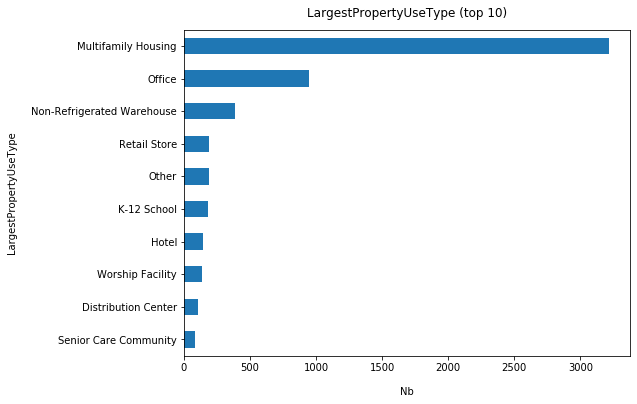

In [34]:
# afficher la répartition par LargestPropertyUseType
dat['LargestPropertyUseType'].value_counts()[:10].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('LargestPropertyUseType', labelpad=14)
plt.title('LargestPropertyUseType (top 10)', y=1.02)

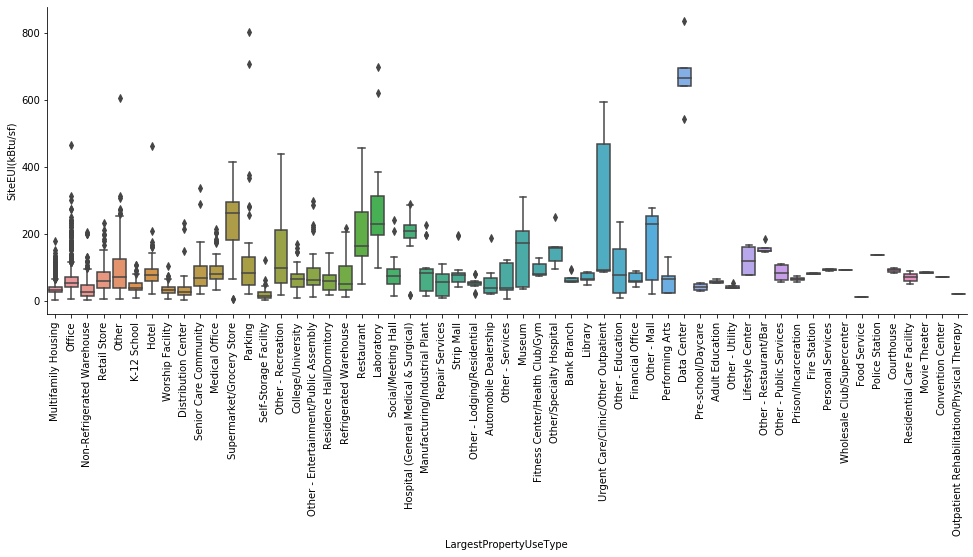

In [35]:
# visualiser les distributions d'EUI selon LargestPropertyUseType
ax = sns.catplot(
    x='LargestPropertyUseType',
    y='SiteEUI(kBtu/sf)',
    kind='box',
    data=dat,
    order=dat['LargestPropertyUseType'].value_counts().index,
    height=5,
    aspect=15/5)
plt.xticks(rotation=90)
plt.show()

- il ne devrait pas y avoir de données manquantes pour LargestPropertyUseType, dans la mesure où il n'y a pas de manque pour PrimaryPropertyType

Text(0.5, 1.02, 'SecondLargestPropertyUseType (top 10)')

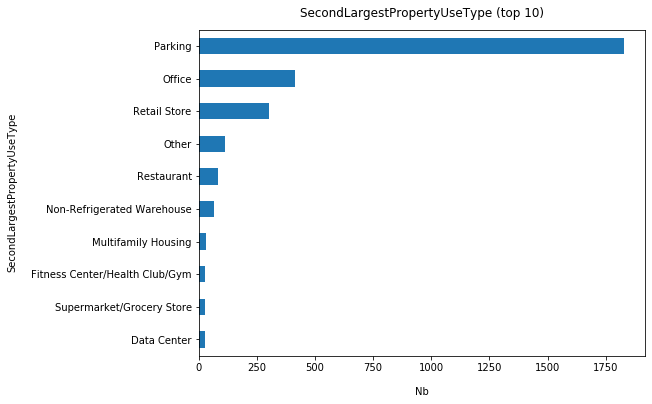

In [36]:
# afficher la répartition par SecondLargestPropertyUseType
dat['SecondLargestPropertyUseType'].value_counts()[:10].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('SecondLargestPropertyUseType', labelpad=14)
plt.title('SecondLargestPropertyUseType (top 10)', y=1.02)

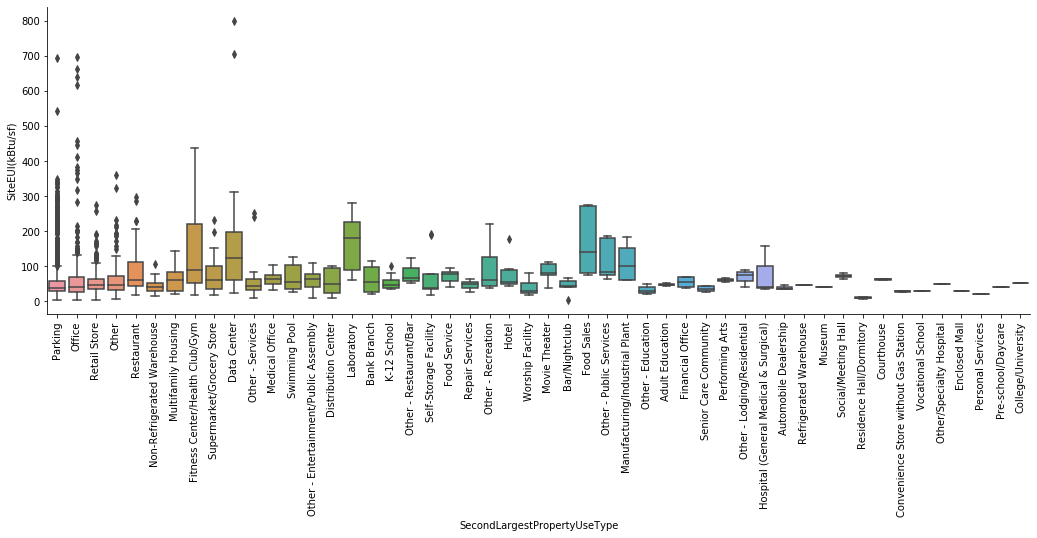

In [37]:
# visualiser les valeurs l'intensité selon le SecondLargestPropertyUseType
ax = sns.catplot(
    x='SecondLargestPropertyUseType',
    y='SiteEUI(kBtu/sf)',
    kind='box',
    data=dat,
    order=dat['SecondLargestPropertyUseType'].value_counts().index,
    height=5,
    aspect=15/5)
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.02, 'ThirdLargestPropertyUseType (top 10)')

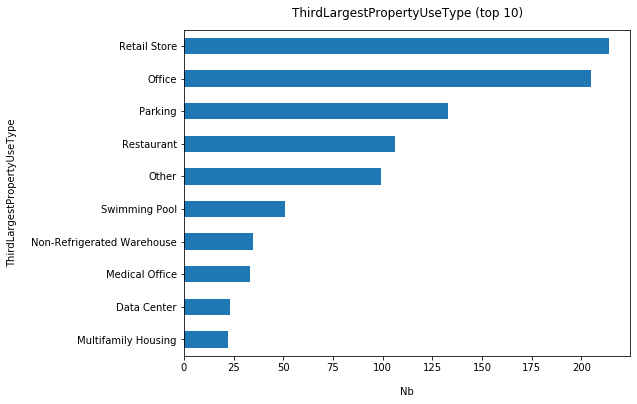

In [38]:
# afficher la répartition par ThirdLargestPropertyUseType
dat['ThirdLargestPropertyUseType'].value_counts()[:10].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('ThirdLargestPropertyUseType', labelpad=14)
plt.title('ThirdLargestPropertyUseType (top 10)', y=1.02)

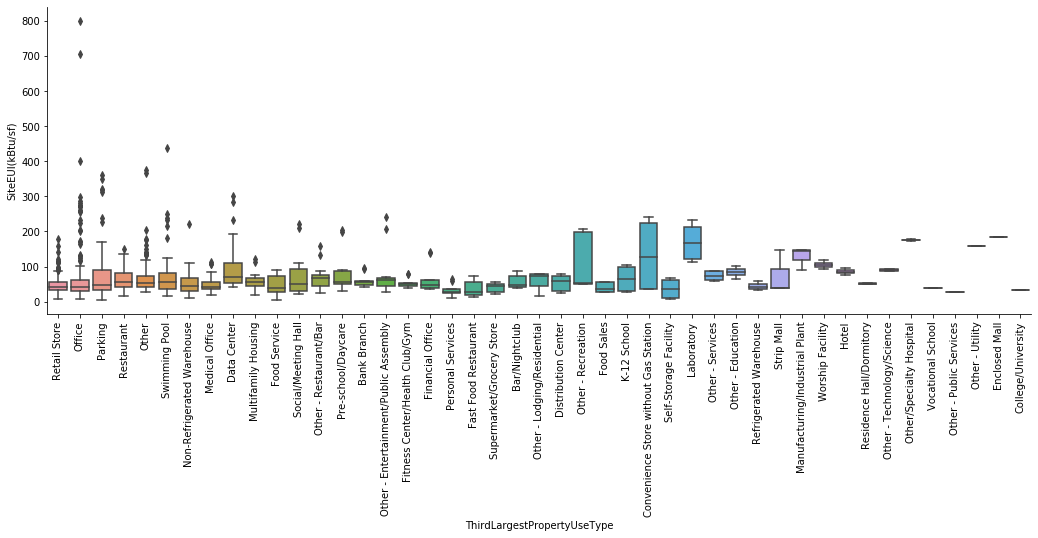

In [39]:
# visualiser la distribution d'EUI selon ThirdLargestPropertyUseType
ax = sns.catplot(
    x='ThirdLargestPropertyUseType',
    y='SiteEUI(kBtu/sf)',
    kind='box',
    data=dat,
    order=dat['ThirdLargestPropertyUseType'].value_counts().index,
    height=5, aspect=15/5)
plt.xticks(rotation=90)
plt.show()

In [40]:
# remplir les valeurs non indiquées par None
dat.fillna({'SecondLargestPropertyUseType': 'None',
            'ThirdLargestPropertyUseType': 'None'},
           inplace=True)

In [41]:
# lister les usages définis pour le 1er usage
largest = dat['LargestPropertyUseType'].unique()
# lister les usages définis pour le 2ème usage
second = dat['SecondLargestPropertyUseType'].unique()
# lister les usages définis pour le 3ème usage
third = dat['ThirdLargestPropertyUseType'].unique()
# consolider la liste d'usetype
resulting_list = list(largest)
resulting_list.extend(x for x in second if x not in resulting_list)
resulting_list.extend(x for x in third if x not in resulting_list)
# contrôler la taille de la liste d'usetype unique
len(resulting_list)

66

In [42]:
# identifier les cas des UseType supplémentaires - inconnus
# transformer en True / False les valeurs de N_D_NbPropUseRange


def nbuse(val):
    if (val == 4):
        return 1
    elif (val < 4):
        return 0
    else:
        return val


# dériver un feature identifiant qu'il y a plus de 3 usages
dat['N_AddUseType'] = dat['N_D_NbPropUseRange'].apply(nbuse).astype(int)

#### Problème soulevé par les observations sur la nature des bâtiments

L'objectif d'efficacité dans la prédiction des résultats concerne explicitement les bâtiments non résidentiels. Le building type principal est "non résidentiel", mais qu'il s'agisse du PrimaryPropertyType (plus de 50% de la surface) ou du LargestPropertyUseType (la plus grande surface), on retrouve des catégories majoritairement résidentielles !? <br/>

Par ailleurs, il y a une proportion importante de valeurs renseignées "Other", qui compromettent la capacité à distinguer les usages excepté sur la catégorie Other - Lodging/Residential. <br/>

On pourrait envisager de recodifier en Residential/ NonRésidential, toutefois en première approche on vérifie que NonResidentiel contient bien au moins un usage non résidentiel, et on décidera quelle restriction appliquer. <br/>

### Nature résidentielle ou non des bâtiments
On recherche un filtre adéquat préservant le maximum de données pour l'objectif des "bâtiments non résidentiels"


In [43]:
#  décomper les building type 'Multifamily' et exemples
cols = ['BuildingType',
        'PrimaryPropertyType',
        'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType']
mask = (dat['BuildingType'].str.contains('Multifamily'))
print(dat[cols][mask].shape)
dat[cols][mask].sample(5)

(3264, 5)


,BuildingType,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
926,Multifamily LR (1-4),Low-Rise Multifamily,Multifamily Housing,Retail Store,None
4893,Multifamily LR (1-4),Low-Rise Multifamily,Multifamily Housing,Parking,None
4064,Multifamily LR (1-4),Low-Rise Multifamily,Multifamily Housing,Parking,None
4994,Multifamily MR (5-9),Mid-Rise Multifamily,Multifamily Housing,Parking,None
1336,Multifamily MR (5-9),Mid-Rise Multifamily,Multifamily Housing,Parking,None


- il serait intéressant de conserver ces building types du fait des autres usages définis qui sont non résidentiels malgré le building type

In [44]:
#  décompter les cas NonResidentiel et PropertyUseType = Multifamily
cols = ['BuildingType',
        'PrimaryPropertyType',
        'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType']
mask = (dat['BuildingType'] == 'NonResidential') & (
     (dat['LargestPropertyUseType'] == 'Multifamily Housing') |
     (dat['SecondLargestPropertyUseType'] == 'Multifamily Housing') |
     (dat['ThirdLargestPropertyUseType'] == 'Multifamily Housing'))
print(dat[cols][mask].shape)
dat[cols][mask].sample(5)

(63, 5)


,BuildingType,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
1156,NonResidential,Small- and Mid-Sized Office,Office,Multifamily Housing,None
1585,NonResidential,Mixed Use Property,Strip Mall,Office,Multifamily Housing
156,NonResidential,Mixed Use Property,Multifamily Housing,Supermarket/Grocery Store,Parking
3089,NonResidential,Mixed Use Property,Multifamily Housing,Other - Entertainment/Public Assembly,None
2753,NonResidential,Small- and Mid-Sized Office,Office,Other,Multifamily Housing


- on peut proposer de limiter la restriction des bâtiments à ceux exclusivement Multifamily + eventuel Parking

In [45]:
# filtre moins restrictif : bâtiments "résidentiels stricts" et exemples
cols = ['BuildingType',
        'PrimaryPropertyType',
        'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType']
mask = (dat['LargestPropertyUseType'] == 'Multifamily Housing') & (
     (dat['SecondLargestPropertyUseType'] == 'None') |
     (dat['SecondLargestPropertyUseType'] == 'Parking')) & (
     (dat['ThirdLargestPropertyUseType'] == 'None'))
print(dat[cols][mask].shape)
dat[cols][~mask].sample(5)

(2549, 5)


,BuildingType,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
2483,NonResidential,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,Food Sales,Office
1255,NonResidential,Restaurant\n,Restaurant,None,None
3520,NonResidential,Warehouse,Non-Refrigerated Warehouse,Office,None
1956,NonResidential,Refrigerated Warehouse,Refrigerated Warehouse,Office,None
3377,NonResidential,Other,Other,Parking,None


In [46]:
# aperçu des données
dat[cols][~mask].sample(5)

,BuildingType,PrimaryPropertyType,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
5147,Nonresidential COS,Warehouse,Non-Refrigerated Warehouse,Other,None
4170,Campus,K-12 School,K-12 School,None,None
4411,NonResidential,Worship Facility,Worship Facility,Parking,None
4012,NonResidential,Retail Store,Retail Store,Office,None
1940,NonResidential,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,Office,None


- on détient un meilleur filtre pour les bâtiments non résidentiels, qui préserve un plus grand nombre de batiments. 

### B.2.2. les données numériques de surface


PropertyGFATotal (0) <br/>
PropertyGFABuilding(s) (0) <br/>
PropertyGFAParking (0) <br/>
LargestPropertyUseTypeGFA (156) <br/>
SecondLargestPropertyUseTypeGFA (3478) <br/>
ThirdLargestPropertyUseTypeGFA (5560) <br/>


source FAQ du site https://portfoliomanager.zendesk.com/ <br/>
The longer answer: Portfolio Manager tracks three different Parking metrics:<br/>

Gross Floor Area (Buildings and Parking) <br/>
Gross Floor Area (Buildings) *used to compute EUI <br/>
Gross Floor Area (Parking) <br/>
If your parking garage is separately metered, we recommend that you exclude your parking energy and parking GFA from Portfolio Manager to get the most accurate ENERGY STAR Score. <br/>

If your parking garage is NOT separately metered, include your parking energy and parking GFA (as a separate Property Use).<br/> Here's how it will be handled: <br/>

Score: Your parking energy will be estimated and subtracted to isolate and assess the performance of the building.<br/>
All other Metrics: Your parking energy will be included (it should be relatively small and therefore have little effect on metrics), but your parking GFA will not be included (because a large parking GFA could skew your metrics).<br/>

Do I include the GFA for a private garage in a townhome/duplex?<br/>
No. Because private residential garages associated with individual townhomes or duplexes do not function the same as “parking garages” and their energy use is very minimal, you should exclude their Gross Floor Area (GFA) when benchmarking. You would not include this GFA in any property uses, it would be considered like an outdoor space.

In [47]:
# lister les features de surfaces totales
Surf = ['PropertyGFATotal',
        'PropertyGFABuilding(s)',
        'PropertyGFAParking']
# lister les features de surface d'usage
SurfUse = ['LargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseTypeGFA']

In [48]:
# retirer les cas valeurs négatives
dat = dat[dat['PropertyGFATotal'] >= 0]
dat = dat[dat['PropertyGFABuilding(s)'] >= 0]
dat = dat[dat['PropertyGFAParking'] >= 0]
dat.shape

(6340, 45)

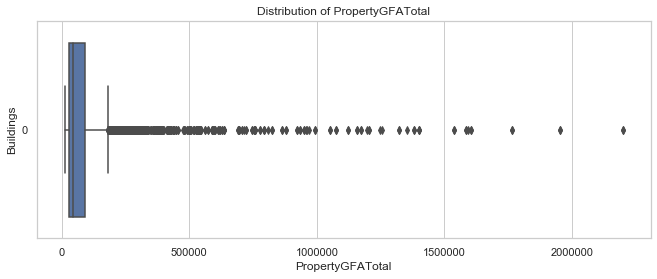

Il y a 100 pourcent(s) des données disponibles, soit 6340 données


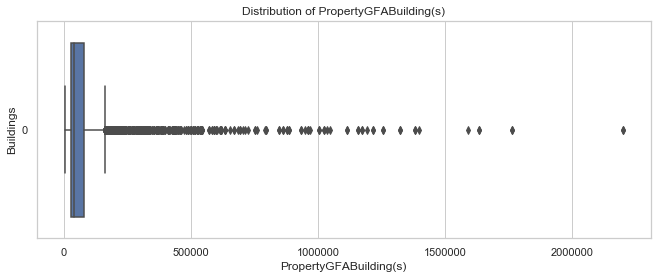

Il y a 100 pourcent(s) des données disponibles, soit 6340 données


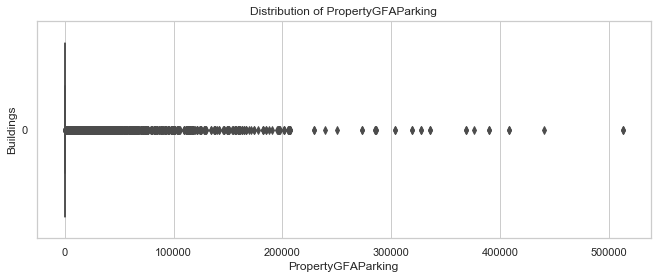

Il y a 100 pourcent(s) des données disponibles, soit 6340 données


In [49]:
# observer les distribution des surfaces totales
for i in Surf:
    plt.figure(figsize=(11, 4))
    x = dat.loc[~dat[i].isnull(), i]
    x = np.array(x)
    sns.set(style='whitegrid')
    sns.boxplot(data=x, orient="h")
    plt.title("Distribution of {}".format(i))
    plt.xlabel(i)
    plt.ylabel('Buildings')
    plt.show()
    print('Il y a %d pourcent(s) des données disponibles, soit %d données'
          % (round(100*((dat.shape[0]-dat[i].isna().sum())/dat.shape[0]), 2),
             (dat.shape[0]-dat[i].isna().sum())))

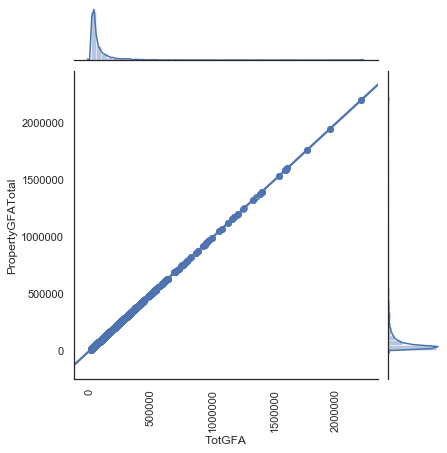

In [50]:
# vérifier que le total est bien celui indiqué
# recalculer un total
dat['TotGFA'] = dat['PropertyGFABuilding(s)'] + dat['PropertyGFAParking']
# afficher le pairplot valeur recalculée sur total indiqué
with sns.axes_style('white'):
    sns.jointplot(dat['TotGFA'], dat['PropertyGFATotal'], data=dat, kind='reg')
    plt.xticks(rotation=90)
    plt.show()

In [51]:
# explorer l'influence des proportions parking vs bâtiment
dat['N_PercentGFAParking'] = round(
    100 * dat['PropertyGFAParking']
    / (dat['PropertyGFAParking']
       + dat['PropertyGFABuilding(s)']))
dat['N_PercentGFABuilding'] = round(
    100 * dat['PropertyGFABuilding(s)']
    / (dat['PropertyGFAParking']
       + dat['PropertyGFABuilding(s)']))

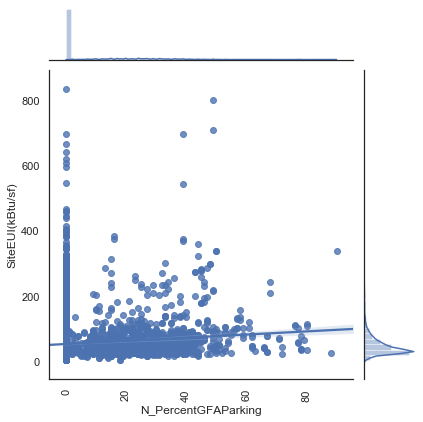

In [52]:
# visualiser l'EUI en fonction des surfaces de parkings
with sns.axes_style('white'):
    sns.jointplot(dat['N_PercentGFAParking'],
                  dat['SiteEUI(kBtu/sf)'],
                  data=dat,
                  kind='reg')
plt.xticks(rotation=90)
plt.show()

- cette observation est plutôt contre-intuitive car excepté les bornes : 0% - 100% parking, qui sont déjà représentés logiquement avec la surface x usage, on observe que plus il y a de surface de parking décompté à part, plus l'intensité d'energie source est élevée. 

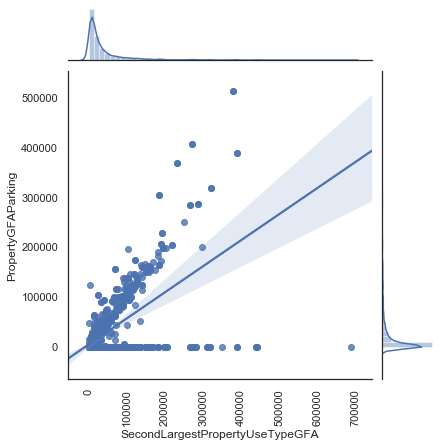

In [53]:
# observer PropertyGFAParking, si 2ème usage est parking (le plus fréquent)
cols = ['PropertyGFAParking',
        'SecondLargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseType']
mask = (dat['SecondLargestPropertyUseType'] == 'Parking')
temp = dat[cols][mask]
temp = temp[temp['SecondLargestPropertyUseTypeGFA'] > 0]
with sns.axes_style('white'):
    sns.jointplot(temp['SecondLargestPropertyUseTypeGFA'],
                  temp['PropertyGFAParking'],
                  data=temp,
                  kind='reg')
    plt.xticks(rotation=90)
    plt.show()

- les données de surface de parking sont globalement erronées. 

In [54]:
# cas où l'usage principal est parking et exemples
cols = ['PropertyGFATotal',
        'PropertyGFAParking',
        'PropertyGFABuilding(s)',
        'LargestPropertyUseTypeGFA',
        'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA',
        'LargestPropertyUseType']
mask = (dat['LargestPropertyUseType'] == 'Parking')
print(dat[cols][mask].shape)
dat[cols][mask].sample(5)

(59, 7)


,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,LargestPropertyUseType
6410,33648,0,33648,83600.0,39000.0,NaN,Parking
5267,36000,0,36000,18000.0,18000.0,NaN,Parking
590,303255,19820,283435,321828.0,298043.0,5636.0,Parking
1420,85750,0,85750,65000.0,20000.0,NaN,Parking
3669,161789,91935,69854,91935.0,69854.0,NaN,Parking


- on s'est assuré à propos du traitement possible des parking que la valeur PropertyGFAParking est à part dans le cas d'un parking non solidaire du batiment, elle ne constitue donc a priori pas une information valorisable dans notre étude. 

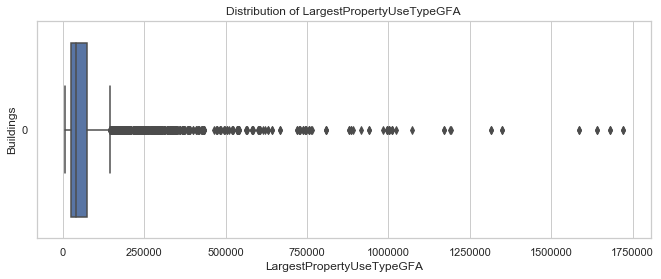

Il y a 100 pourcent(s) des données disponibles, soit 6340 données


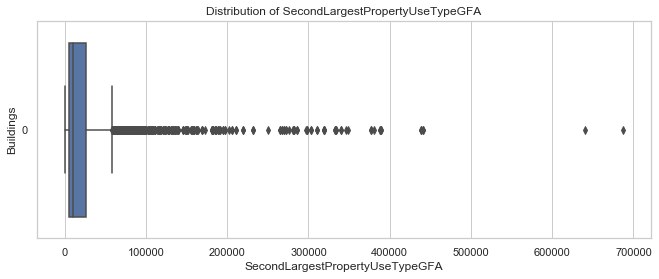

Il y a 50 pourcent(s) des données disponibles, soit 3181 données


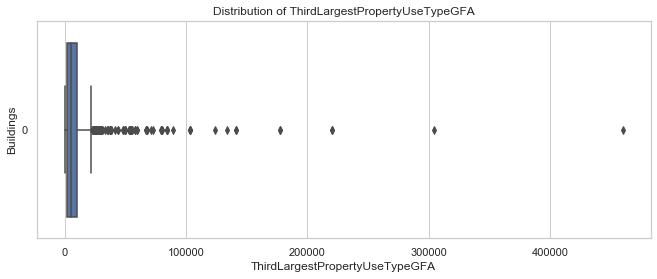

Il y a 17 pourcent(s) des données disponibles, soit 1132 données


In [55]:
# observer les distribution des surfaces par 1er, 2ème 3ème usage
for i in SurfUse:
    plt.figure(figsize=(11, 4))
    x = dat.loc[~dat[i].isnull(), i]
    x = np.array(x)
    sns.set(style='whitegrid')
    sns.boxplot(data=x, orient="h")
    plt.title("Distribution of {}".format(i))
    plt.xlabel(i)
    plt.ylabel('Buildings')
    plt.show()
    print('Il y a %d pourcent(s) des données disponibles, soit %d données'
          % (round(100 * ((
              dat.shape[0] - dat[i].isna().sum())
              / dat.shape[0]), 2),
             (dat.shape[0]-dat[i].isna().sum())))

In [56]:
# considérer nulles les valeurs non indiquée pour les 2eme et 3eme usage
dat.fillna({'SecondLargestPropertyUseTypeGFA': 0,
            'ThirdLargestPropertyUseTypeGFA': 0},
           inplace=True)

In [57]:
# calculer une nouvelle surface sommant les 3 usages principaux
dat['N_TotUseGFA'] = dat['LargestPropertyUseTypeGFA'] + dat['SecondLargestPropertyUseTypeGFA'] + dat['ThirdLargestPropertyUseTypeGFA']

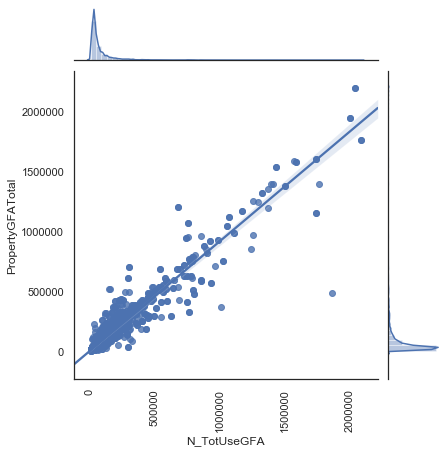

In [58]:
# visualiser l'écart de valeur somme des 3 usages / surface totale
with sns.axes_style('white'):
    sns.jointplot(dat['N_TotUseGFA'],
                  dat['PropertyGFATotal'],
                  data=dat,
                  kind='reg')
    plt.xticks(rotation=90)
    plt.show()

- La surface reconstruite N_TotUseGFA pose un problème de validité dans la mesure où elle peut être supérieure à la surface totale. cela implique de ne pas avoir de surface restante dans le cas de plus de 3 usages, elle indiquera une part d'usage d'autant plus erronéequ'il y aura d'écart avec la surface totale et d'usages supplémentaires associés à des surfaces.

In [59]:
# calculer une proportion de surface par 1er, 2ème et 3ème usage
dat['LargestProp'] = dat['LargestPropertyUseTypeGFA'] / dat['PropertyGFABuilding(s)']
dat['SecLargestProp'] = dat['SecondLargestPropertyUseTypeGFA'] / dat['PropertyGFABuilding(s)']
dat['ThirdLargestProp'] = dat['ThirdLargestPropertyUseTypeGFA'] / dat['PropertyGFABuilding(s)']

2:80: E501 line too long (85 > 79 characters)
3:80: E501 line too long (94 > 79 characters)


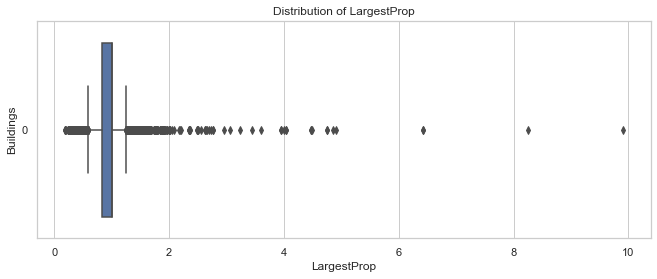

Il y a 100 pourcent(s) des données disponibles, soit 6340 données


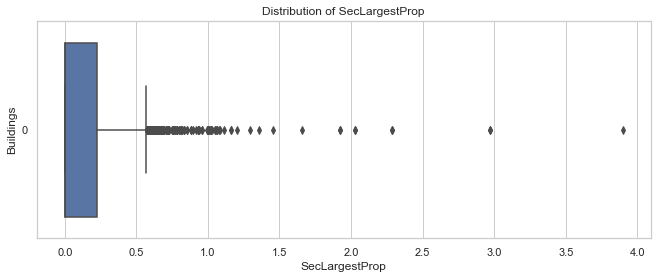

Il y a 100 pourcent(s) des données disponibles, soit 6340 données


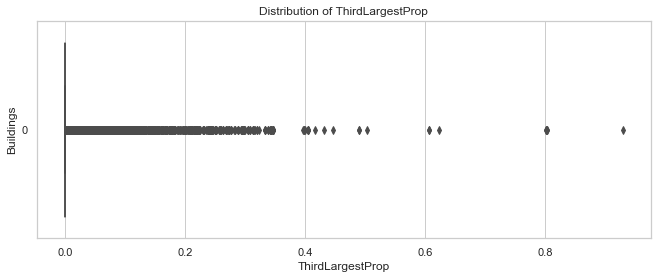

Il y a 100 pourcent(s) des données disponibles, soit 6340 données


In [60]:
# lister ces proportions calculées
Check = ['LargestProp', 'SecLargestProp', 'ThirdLargestProp']

# afficher la distribution de ces valeurs
for i in Check:
    plt.figure(figsize=(11, 4))
    x = dat.loc[~dat[i].isnull(), i]
    x = np.array(x)
    sns.set(style='whitegrid')
    sns.boxplot(data=x, orient="h")
    plt.title("Distribution of {}".format(i))
    plt.xlabel(i)
    plt.ylabel('Buildings')
    plt.show()
    print('Il y a %d pourcent(s) des données disponibles, soit %d données'
          % (round(100 * ((
              dat.shape[0] - dat[i].isna().sum())
              / dat.shape[0]), 2),
             (dat.shape[0]-dat[i].isna().sum())))

In [61]:
# considerer la surface restante
dat['OtherPropertyUseTypeGFA'] = dat['PropertyGFATotal'] - dat['N_TotUseGFA']

In [62]:
# compter le nb de cas où cette surface serait négative
dat[dat['OtherPropertyUseTypeGFA'] < 0].shape

(1417, 53)

In [63]:
# retirer les cas de valeurs négatives
dat['OtherPropertyUseTypeGFA'] = dat['OtherPropertyUseTypeGFA'].clip(lower=0)

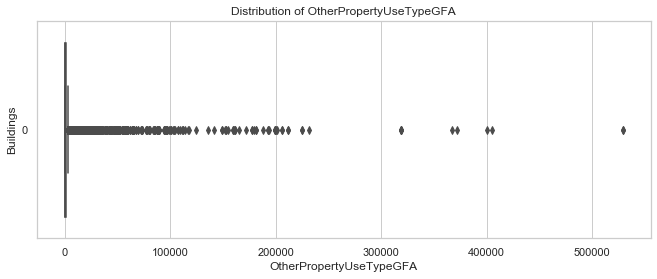

In [64]:
# afficher la distribution de cette surface résiduelle
plt.figure(figsize=(11, 4))
x = dat.loc[~dat['OtherPropertyUseTypeGFA'].isnull(),
            'OtherPropertyUseTypeGFA']
x = np.array(x)
sns.set(style='whitegrid')
sns.boxplot(data=x, orient="h")
plt.title("Distribution of {}".format('OtherPropertyUseTypeGFA'))
plt.xlabel('OtherPropertyUseTypeGFA')
plt.ylabel('Buildings')
plt.show()

In [65]:
# Ranger dans AddUseType la proportion de surface associée
dat['N_AddUseType'] = dat['N_AddUseType'] * dat['OtherPropertyUseTypeGFA'] / dat['PropertyGFABuilding(s)']

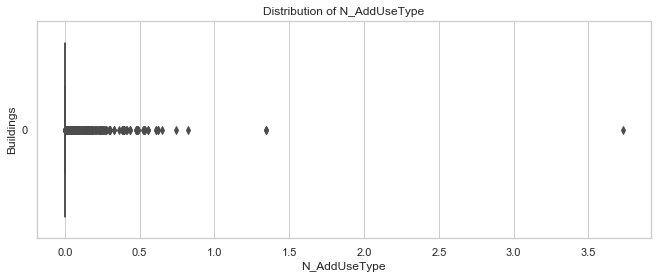

In [66]:
# afficher la distribution de cette proportion de surface complémentaire
plt.figure(figsize=(11, 4))
x = dat.loc[~dat['N_AddUseType'].isnull(), 'N_AddUseType']
x = np.array(x)
sns.set(style='whitegrid')
sns.boxplot(data=x, orient="h")
plt.title("Distribution of {}".format('N_AddUseType'))
plt.xlabel('N_AddUseType')
plt.ylabel('Buildings')
plt.show()


In [67]:
# retirer ces cas qui sont abérants
dat = dat[dat['N_AddUseType'] < 1]
# contrôler la taille des données
print(dat.shape)

(6337, 53)


In [68]:
# vérifier s'il reste des valeurs non déterminées LargestPropertyUseTypeGFA?
dat[dat['LargestPropertyUseTypeGFA'].isna()].shape

(0, 53)

In [69]:
# vérifier s'il y a des cas d'usages inconnus avec plus de 3 usages
cols = ['OSEBuildingID',
        'ListOfAllPropertyUseTypes',
        'LargestPropertyUseType',
        'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType',
        'N_AddUseType',
        'N_NbPropUse']
mask = (dat['N_NbPropUse'] > 3)
print(dat[cols][mask].shape)
dat[cols][mask].sample(14)

(412, 7)


,OSEBuildingID,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,N_AddUseType,N_NbPropUse
5670,25932,"Medical Office, Office, Other, Restaurant, Retail Store",Retail Store,Office,Restaurant,0.000000,5
3558,440,"Data Center, Financial Office, Office, Other, Parking, Restaurant",Parking,Data Center,Office,0.154308,6
5778,26331,"Food Service, Library, Office, Parking",Office,Parking,Food Service,0.000000,4
6483,50225,"Fitness Center/Health Club/Gym, Food Service, Office, Other - Recreation, Pre-school/Daycare",Other - Recreation,Fitness Center/Health Club/Gym,Pre-school/Daycare,0.036522,5
141,238,"Data Center, Distribution Center, Office, Other, Parking",Office,Distribution Center,Parking,0.000000,5
3428,264,"Financial Office, Multifamily Housing, Parking, Retail Store, Supermarket/Grocery Store",Multifamily Housing,Supermarket/Grocery Store,Parking,0.000000,5
3434,278,"K-12 School, Medical Office, Office, Restaurant, Retail Store, Senior Care Community",Senior Care Community,Medical Office,K-12 School,0.046737,6
65,100,"Office, Other, Parking, Retail Store",Office,Parking,Other,0.000000,4
4103,20133,"Multifamily Housing, Office, Restaurant, Retail Store, Social/Meeting Hall, Supermarket/Grocery Store",Multifamily Housing,Office,Restaurant,0.490171,6
3343,65,"Hotel, Parking, Restaurant, Retail Store",Hotel,Parking,Retail Store,0.091019,4


- cela conduit à ne détecter qu'une seule valeur réellement erronée
- il resterait donc à trouver comment ne pas dévoyer l'apprentissage du fait des nan dans les catégories d'usage pour pouvoir toutes les exploiter.
- on écarte dans un premier temps les 2ème et 3ème plus gros usage.


### B.2.3. les données numériques caractéristant les bâtiments :

- Yearbuilt : date de construction ou de rénovation <br/>

In [70]:
# trouver les bornes de date de construction ou rénovation
print(dat['YearBuilt'].max())
print(dat['YearBuilt'].min())

2015
1900


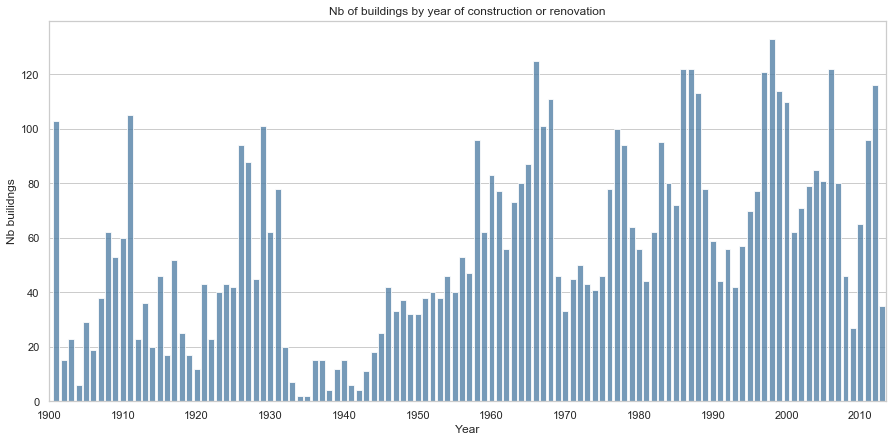

In [71]:
# compter les bâtiments par année de construction ou rénovation
cnt = dat['YearBuilt'].value_counts().sort_index(axis=0, ascending=True)
plt.figure(figsize=(15, 7))
sns.barplot(cnt.index, cnt.values, color='steelblue', alpha=0.8)
plt.xticks(np.arange(-1, 119, 10), labels=np.arange(1900, 2020, 10))
plt.title('Nb of buildings by year of construction or renovation')
plt.ylabel('Nb builidngs', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show()

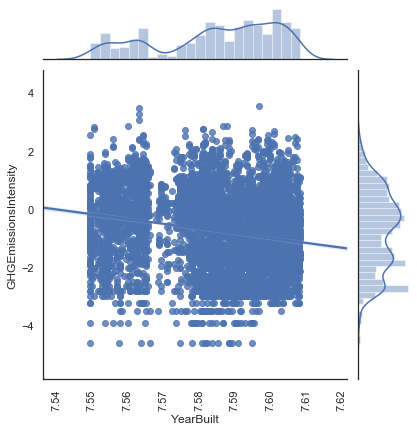

In [72]:
# observer l'effet de l'âge de construction ou rénovation sur l'intensité
with sns.axes_style('white'):
    sns.jointplot(np.log(dat['YearBuilt']),
                  np.log(dat['GHGEmissionsIntensity']),
                  data=dat,
                  kind='reg')
    plt.xticks(rotation=90)
    plt.show()

- pour rendre cette donnée de Profil plus exploitable, on va la transformer en "ancienneté" du bâtiment, qui est plus pertinente du point de vue de la consommation énergétique d'un bâtiment (isolation). 

In [73]:
# calculer un âge de construction ou de rénovation
dat['N_BuildingAge'] = dat['DataYear']-dat['YearBuilt']+1

In [74]:
# vérifier les bornes de l'âge
print(dat['N_BuildingAge'].max())
print(dat['N_BuildingAge'].min())

117
1


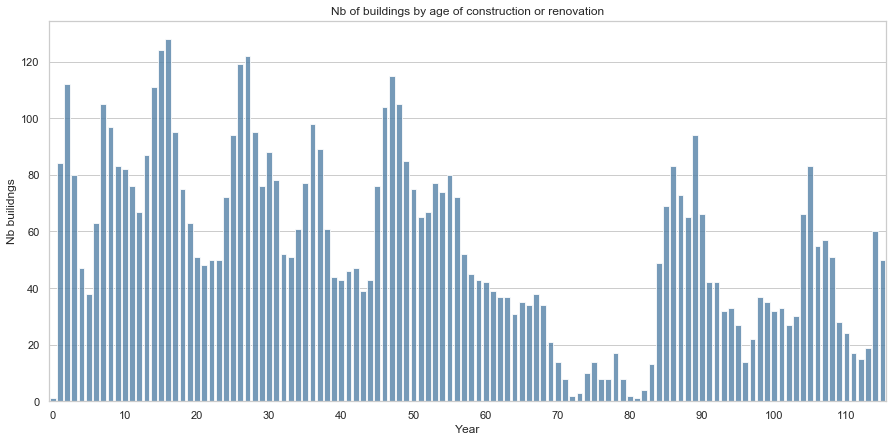

In [75]:
# afficher le nombre de bâtiments pour chaque âge
cnt = dat['N_BuildingAge'].value_counts().sort_index(axis=0, ascending=True)
plt.figure(figsize=(15, 7))
sns.barplot(cnt.index, cnt.values, color='steelblue', alpha=0.8)
plt.xticks(np.arange(0, 116, 10), labels=np.arange(0, 116, 10))
plt.title('Nb of buildings by age of construction or renovation')
plt.ylabel('Nb builidngs', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.show()

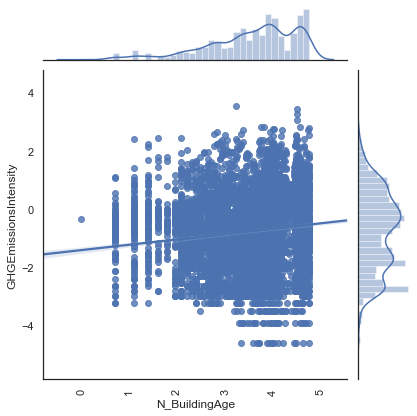

In [76]:
# observer l'effet de l'âge de construction ou rénovation sur l'intensité
with sns.axes_style('white'):
    sns.jointplot(np.log(dat['N_BuildingAge']),
                  np.log(dat['GHGEmissionsIntensity']),
                  data=dat,
                  kind='reg')
    plt.xticks(rotation=90)
    plt.show()

- NumberofBuildings & NumberofFloors

In [77]:
# corriger le type de nb de bâtiments sur un site
dat['NumberofBuildings'] = dat['NumberofBuildings'].astype('int64')

In [78]:
# lister les valeurs possibles de nb de bâtiments sur un site
np.sort(dat['NumberofBuildings'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 16, 23, 27, 39],
      dtype=int64)

Text(0.5, 1.02, 'NumberofBuildings (top 10)')

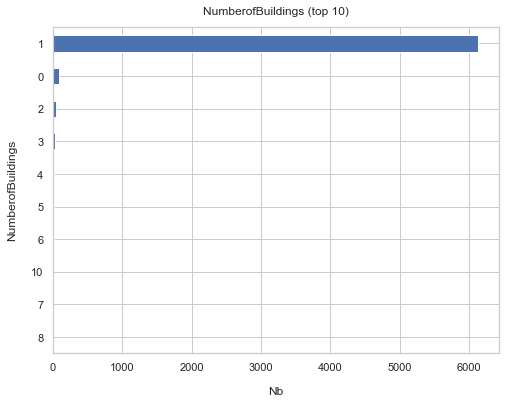

In [79]:
# afficher la répartition des bâtiments par nb de bâtiments sur le site
dat['NumberofBuildings'].value_counts()[:10].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('NumberofBuildings', labelpad=14)
plt.title('NumberofBuildings (top 10)', y=1.02)

In [80]:
# affichier les valeurs précises
print(dat[dat['NumberofBuildings'] == 0].shape)
print(dat[dat['NumberofBuildings'] == 1].shape)
print(dat[dat['NumberofBuildings'] == 2].shape)
print(dat[dat['NumberofBuildings'] == 3].shape)

(91, 54)
(6132, 54)
(39, 54)
(25, 54)


In [81]:
# lister quelques exemples de zero bâtiments
dat.loc[dat['NumberofBuildings'] == 0,
        ['PropertyName',
         'PrimaryPropertyType',
         'LargestPropertyUseType',
         'LargestPropertyUseTypeGFA']].sample(5)

,PropertyName,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA
4428,419 QAAN BUILDING,Low-Rise Multifamily,Multifamily Housing,21120.0
5993,Mezzo Condominium,Low-Rise Multifamily,Multifamily Housing,28744.0
6266,Broadway Building,Mixed Use Property,Multifamily Housing,88132.0
6176,THE KENNEY,Low-Rise Multifamily,Multifamily Housing,177686.0
4571,(ID21659) ALDER HOUSE,Low-Rise Multifamily,Multifamily Housing,33192.0


- les "0" buildings sont manifestement erronés puisqu'il s'agit de bâtiments et qu'ils ont des surface : cela rend le feature irréaliste, et il serait inefficace d'essayer de le reconstruire. On ne considèrera donc pas ce feature.

In [82]:
# donner la valeur 1 aux cas 0 bâtiments
dat['NumberofBuildings'].replace(0, 1, inplace=True)

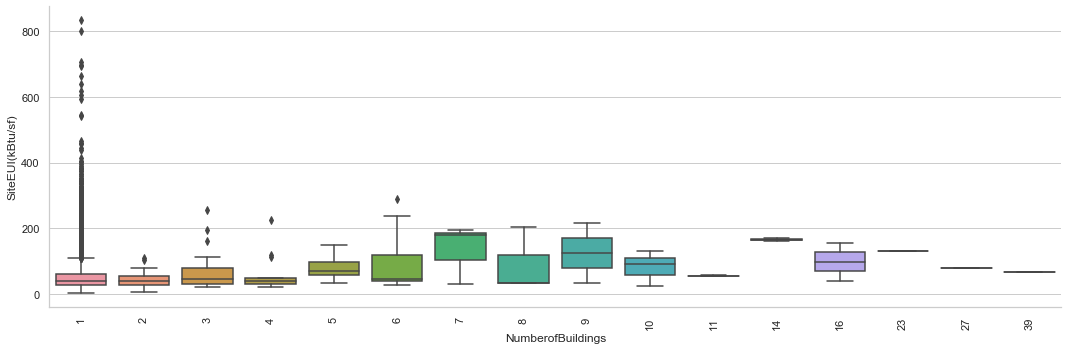

In [83]:
# visualiser la distrib de EUI en fonction des nb de bâtiments par site
ax = sns.catplot(x='NumberofBuildings',
                 y='SiteEUI(kBtu/sf)',
                 kind='box',
                 data=dat,
                 order=np.sort(dat['NumberofBuildings'].unique()),
                 height=5,
                 aspect=15/5)
plt.xticks(rotation=90)
plt.show()

In [84]:
# regrouper en 2 catégories le nb de bâtiments tout en conservant valeur num
bins = [0, 2, np.inf]
values = [1, 2]
dat['N_D_NbofBuildingsRange'] = pd.cut(dat['NumberofBuildings'], bins, labels=values)

Text(0.5, 1.02, 'NumberofBuildings')

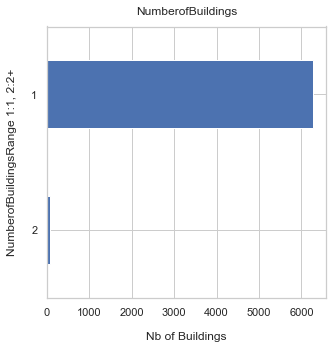

In [85]:
# afficher la répartition dans les 2 catégories
dat['N_D_NbofBuildingsRange'].value_counts()[:10].plot(
    kind='barh',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb of Buildings', labelpad=14)
plt.ylabel('NumberofBuildingsRange 1:1, 2:2+', labelpad=14)
plt.title('NumberofBuildings', y=1.02)

In [86]:
# compter précisément le nb de bâtiments différent de 1
dat[dat['N_D_NbofBuildingsRange'] == 2].shape

(75, 55)

- Nombre d'étages

In [87]:
# lister les valeurs de nb d'étages
np.sort(dat['NumberofFloors'].unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 38., 39.,
       40., 41., 42., 46., 47., 49., 55., 56., 63., 76., 99., nan])

In [88]:
# lister quelques exemples de zero étage
print(dat[dat['NumberofFloors'] == 0].shape)
dat.loc[dat['NumberofFloors'] == 0,
        ['PrimaryPropertyType',
         'LargestPropertyUseType',
         'LargestPropertyUseTypeGFA',
         'SiteEUI(kBtu/sf)']].sample(5)

(19, 55)


,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf)
477,Medical Office,Medical Office,200184.0,92.700000
159,Hotel,Hotel,495536.0,115.700000
6396,Residence Hall,Residence Hall/Dormitory,97040.0,40.099998
478,Mixed Use Property,Parking,385196.0,94.800000
6254,Medical Office,Medical Office,28050.0,78.199997


In [89]:
# lister quelques exemples de nb étage inconnu
print(dat[dat['NumberofFloors'].isna()].shape)
dat.loc[dat['NumberofFloors'].isna(),
        ['PrimaryPropertyType',
         'LargestPropertyUseType',
         'LargestPropertyUseTypeGFA',
         'SiteEUI(kBtu/sf)']].sample(5)

(8, 55)


,PrimaryPropertyType,LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf)
3169,Other,Other - Recreation,564258.0,30.6
3131,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,349953.0,37.2
3269,Other,Repair Services,20983.0,43.5
3132,Medical Office,Medical Office,31843.0,62.1
3271,Other,Pre-school/Daycare,40265.0,48.6


In [90]:
# remplacer les nb étages vides ou nuls par 1
dat['NumberofFloors'].replace(0, 1, inplace=True)
dat['NumberofFloors'].fillna(1, inplace=True)

In [91]:
order = [i+1 for i in range(10)]

Text(0.5, 1.02, 'NumberofFloors (1 to 8 among top 10)')

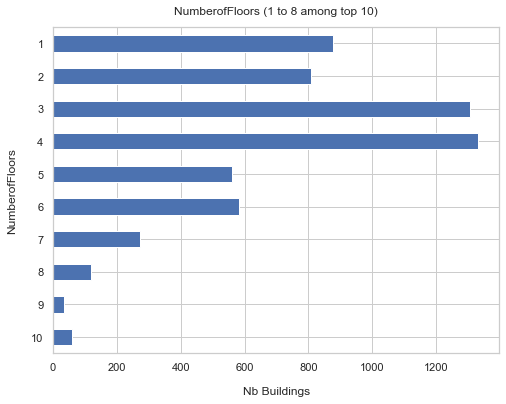

In [92]:
dat['NumberofFloors'].value_counts().loc[order].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb Buildings', labelpad=14)
plt.ylabel('NumberofFloors', labelpad=14)
plt.title('NumberofFloors (1 to 8 among top 10)', y=1.02)

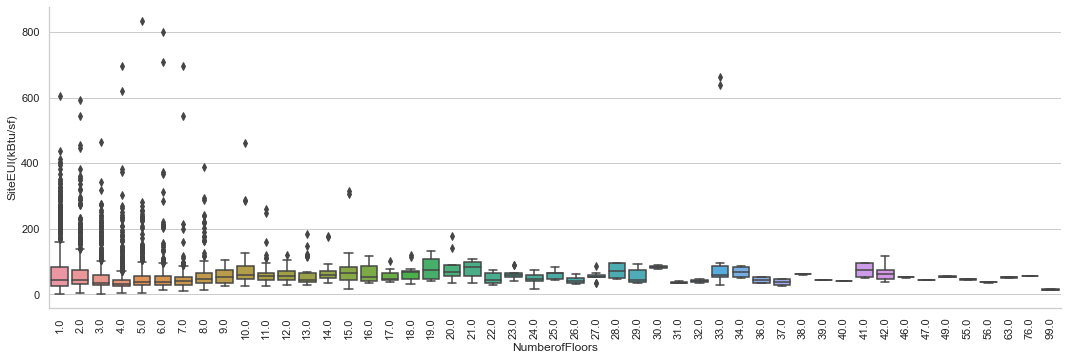

In [93]:
# visualiser l'intensité d'énergie selon le nb d'étages
ax = sns.catplot(x='NumberofFloors',
                 y='SiteEUI(kBtu/sf)',
                 kind='box',
                 data=dat,
                 order=np.sort(dat['NumberofFloors'].unique()),
                 height=5,
                 aspect=15/5)
plt.xticks(rotation=90)
plt.show()

- l'intensité d'energie moyenne varie peu en fonction du nombre d'étages, toutefois celle-ci est d'autant moins dispersée qu'il y a beaucoup d'étages

In [94]:
# catégoriser le nb d'étages en conservant une valeur num.
bins = [0, 2, 4, 7, 10, 21, np.inf]
values = [1, 2, 3, 4, 5, 6]
dat['N_D_NbofFloorsRange'] = pd.cut(dat['NumberofFloors'], bins, labels=values)

Text(0.5, 1.02, 'N_D_NbofFloorsRange')

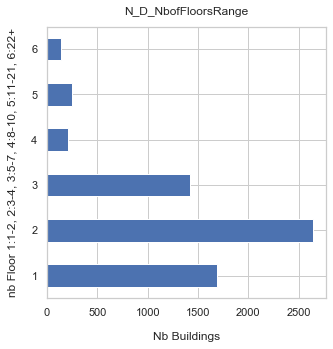

In [95]:
# afficher la nouvelle répartition (attention à la légende axe y)
order = [i+1 for i in range(6)]
dat['N_D_NbofFloorsRange'].value_counts().loc[order].plot(
    kind='barh',
    figsize=(5, 5))
plt.xlabel('Nb Buildings', labelpad=14)
plt.ylabel('nb Floor 1:1-2, 2:3-4, 3:5-7, 4:8-10, 5:11-21, 6:22+', labelpad=14)
plt.title('N_D_NbofFloorsRange', y=1.02)

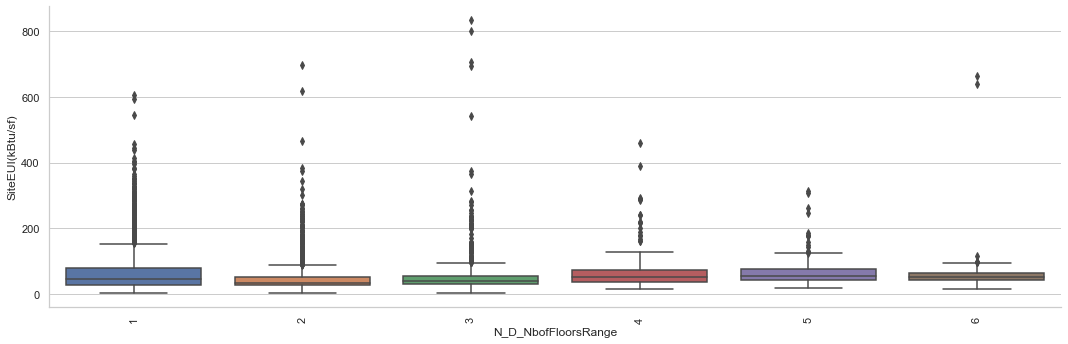

In [96]:
# visualiser l'intensité d'énergie selon les catégories d'étages
ax = sns.catplot(x='N_D_NbofFloorsRange',
                 y='SiteEUI(kBtu/sf)',
                 kind='box',
                 data=dat,
                 height=5,
                 aspect=15/5)
plt.xticks(rotation=90)
plt.show()

### B.2.4. les données de Localisation 

- CouncilDistrictCode est une catégorie maglré son dtype numérique, on trouve des cartes des zones géographiques correspondantes.

In [97]:
# corriger le type de CouncilDistrictCode
dat['CouncilDistrictCode'] = dat['CouncilDistrictCode'].astype('str')
order = dat['CouncilDistrictCode'].unique().tolist()
order.sort()
order

['1', '2', '3', '4', '5', '6', '7']

Text(0.5, 1.02, 'CouncilDistrictCode')

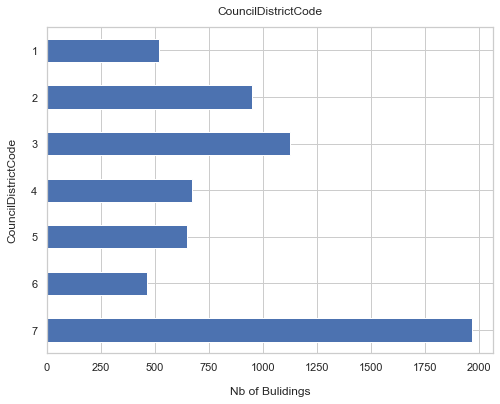

In [98]:
# affichier la répartition selon le CouncilDistrictCode
dat['CouncilDistrictCode'].value_counts().loc[order].plot(
    kind='barh',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb of Bulidings', labelpad=14)
plt.ylabel('CouncilDistrictCode', labelpad=14)
plt.title('CouncilDistrictCode', y=1.02)

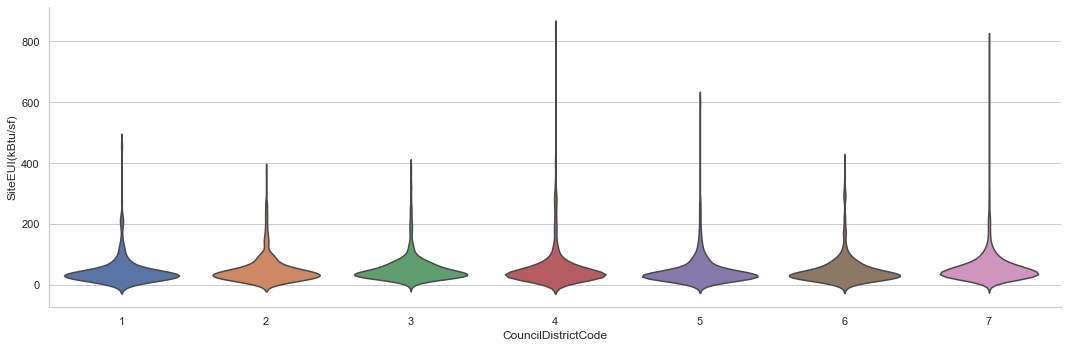

In [99]:
# visualiser les valeurs de EUI selon le CouncilDistrictCode
ax = sns.catplot(x='CouncilDistrictCode',
                 y='SiteEUI(kBtu/sf)',
                 kind="violin",
                 inner=None,
                 data=dat,
                 height=5,
                 aspect=15/5)
plt.xticks(rotation=0)
plt.show()

- le découpage CouncilDistrictCode ne présente pas à première vue d'écart significatif en densité d'énergie utilisée

In [100]:
# lister les quartiers
dat['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'BALLARD',
       'GREATER DUWAMISH', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'North',
       'Delridge', 'Ballard', 'Northwest', 'Central',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [101]:
# remédier aux soucis de casse et termes erronés
dat['Neighborhood'] = dat[['Neighborhood']].apply(lambda col: col.str.upper())
dat['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)

In [102]:
# mesurer la taille de la liste obtenue
dat['Neighborhood'].unique().size

13

Text(0.5, 1.02, 'Neighborhood')

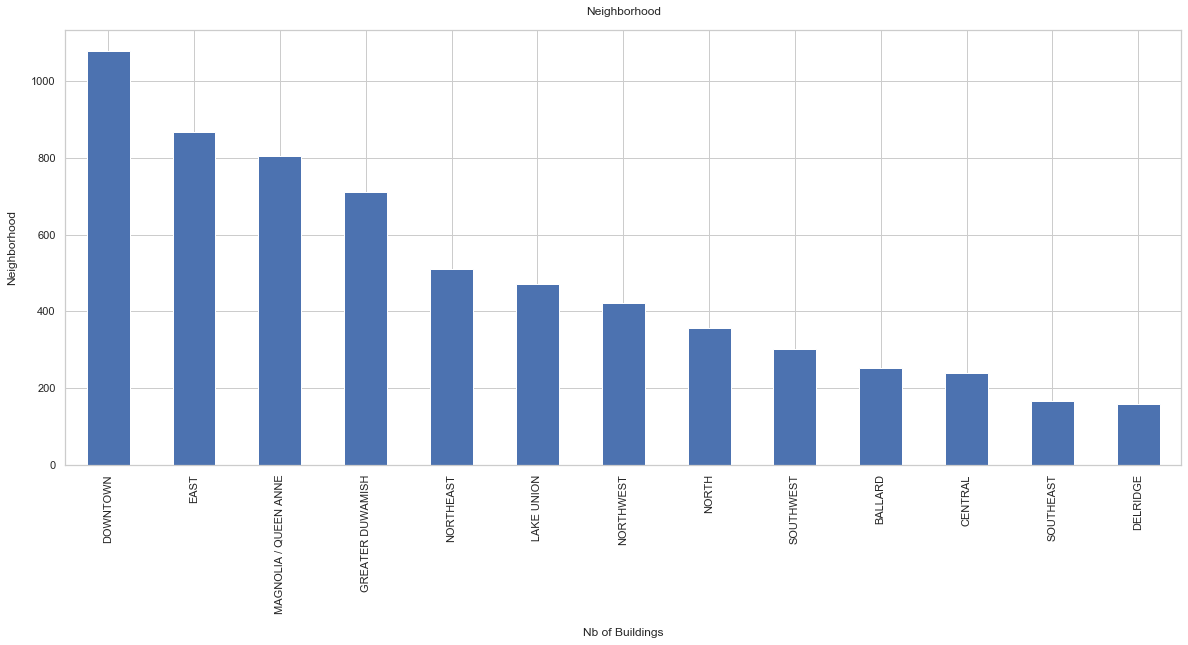

In [103]:
# afficher la répartition par quartier
dat['Neighborhood'].value_counts().plot(kind='bar', figsize=(20, 8))
plt.xlabel('Nb of Buildings', labelpad=14)
plt.ylabel('Neighborhood', labelpad=14)
plt.title('Neighborhood', y=1.02)

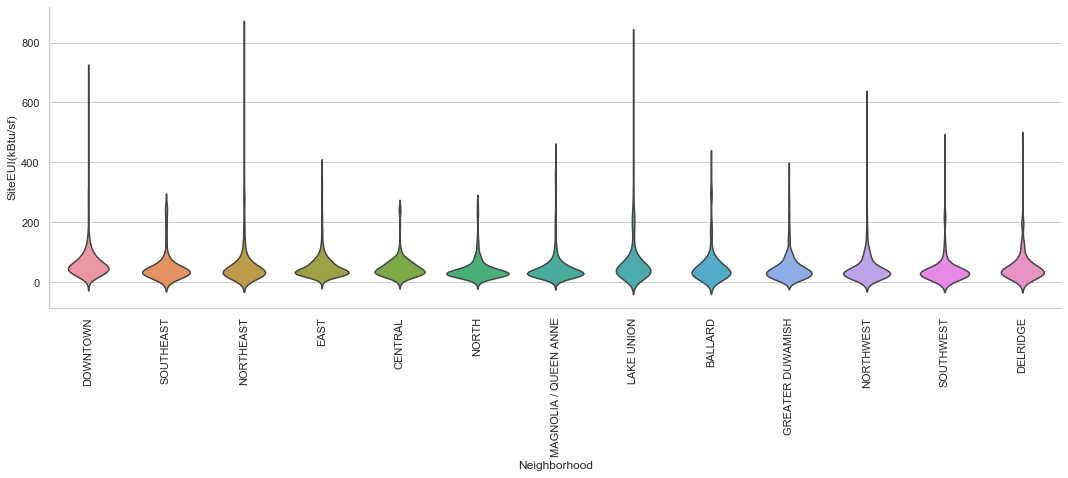

In [104]:
# visualiser l'EUI par quartier
ax = sns.catplot(x='Neighborhood',
                 y='SiteEUI(kBtu/sf)',
                 kind="violin",
                 inner=None,
                 data=dat,
                 height=5,
                 aspect=15/5)
plt.xticks(rotation=90)
plt.show()

- le découpage Neighborhood ne présente pas à première vue d'écart significatif en densité d'énergie utilisée

- le découpage Neighborhood est néanmoins plus fin que celui des CouncilDistrictCode.

In [105]:
# corriger le type de Latitude et Longitude
dat['Latitude'] = dat['Latitude'].astype('float64')
dat['Longitude'] = dat['Longitude'].astype('float64')

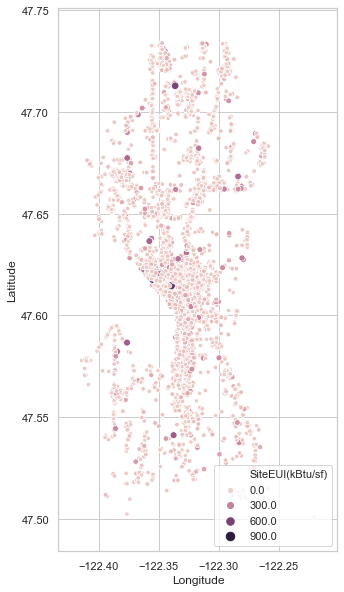

In [106]:
# affichier la répartion (carte) avec taille et couleur selon l'EUI
fig, ax = plt.subplots(figsize=(5, 10))
sns.scatterplot(x='Longitude',
                y='Latitude',
                data=dat,
                hue=dat['SiteEUI(kBtu/sf)'],
                size=dat['SiteEUI(kBtu/sf)'])

- excepté pour reconnaitre la carte de Seattle, ces données ne semblent pas indiquer de tendance.

### B.2.5. Features inutiles et restriction aux bâtiments non destinés à l'habitation

Il s'agit de retirer les features ne présentant pas d'information utile.

On pourra également ici enrichir le feature outlier des valeurs observées.

In [107]:
# retirer les features inutiles
Drop = ['Address',
        'City',
        'PropertyName',
        'State',
        'ListOfAllPropertyUseTypes',
        'TaxParcelIdentificationNumber',
        'ZipCode',
        'Comments',
        'YearsENERGYSTARCertified',
        'ComplianceStatus',
        'Outlier',
        'PrimaryPropertyType',
        'N_NbPropUse',
        'TotGFA']
dat.drop(Drop, axis=1, inplace=True)

In [108]:
# contrôler la taille des données
dat.shape

(6337, 42)

In [109]:
# compter le nb de bâtiments non résidentiels au sens du BuildingType
print(dat[~(dat['BuildingType'].str.contains('Multifamily'))].shape)

(3074, 42)


In [110]:
# compter le nb de bâtiments non résidentiels - méthode "stricte"
print(dat[~(((dat['LargestPropertyUseType'] == 'Multifamily Housing') & (
    (dat['SecondLargestPropertyUseType'] == 'None')) |
    (dat['SecondLargestPropertyUseType'] == 'Parking')) & (
    (dat['ThirdLargestPropertyUseType'] == 'None')))].shape)

(3331, 42)


In [111]:
# appliquer la séléction "stricte"
datclean = dat[~(((dat['LargestPropertyUseType'] == 'Multifamily Housing') & (
    (dat['SecondLargestPropertyUseType'] == 'None')) |
    (dat['SecondLargestPropertyUseType'] == 'Parking')) & (
    (dat['ThirdLargestPropertyUseType'] == 'None')))]

In [112]:
# compter le nombre de données conservées du fait de la restriction fine
datclean[datclean['BuildingType'].str.contains('Multifamily')].shape

(691, 42)

- export des données complètes ou restreintes (dataclean) aux non résidentiels

In [113]:
# exporter des dataframes
dat.to_csv('dat3.csv', index=False)
datclean.to_csv('datclean.csv', index=False)